In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ml-project-2-team-slo/source

/content/drive/MyDrive/ml-project-2-team-slo/source


In [3]:
#import libraries
%matplotlib inline
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader

%load_ext autoreload
%autoreload 2

In [4]:
#import files
from load_datas import *
from constants import *
from visualization import *
from data_processing import *
from cnn import *
from helpers import *
from data_augmentation import *

In [5]:
imgs, gt_imgs = load_datas(NB_IMAGES_MAX)

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


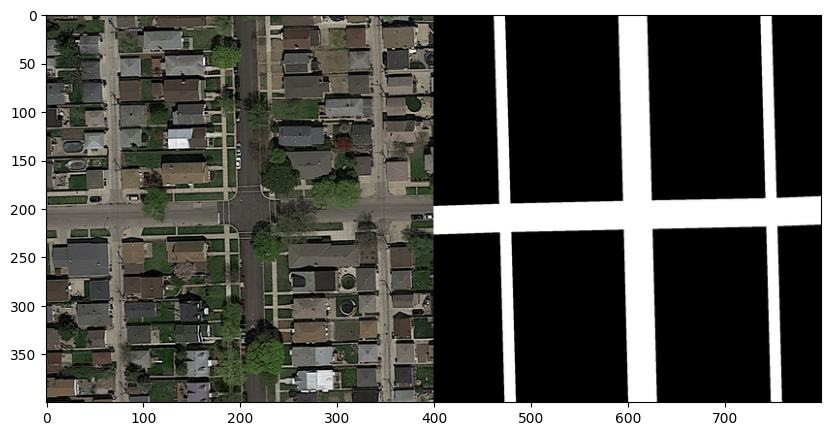

In [6]:
visualize(imgs, gt_imgs)

In [7]:
def compute_mean_std(imgs):
        """Compute mean and standard deviation of the train set."""
        print("Computing mean and std...")
        mean_r = np.mean(imgs[:, 0, :, :])
        mean_g = np.mean(imgs[:, 1, :, :])
        mean_b = np.mean(imgs[:, 2, :, :])

        means = np.array([mean_r, mean_g, mean_b])

        std_r = np.std(imgs[:, 0, :, :])
        std_g = np.std(imgs[:, 1, :, :])
        std_b = np.std(imgs[:, 2, :, :])

        stds = np.array([std_r, std_g, std_b])

        return means, stds

In [8]:
means, stds = compute_mean_std(imgs)
Augmented_Images = DataAugmentation(imgs, means, stds)
Augmented_Images = Augmented_Images.noisyImages()

Computing mean and std...


In [ ]:
set_gt = np.tile(A=gt_imgs,reps=(2,1,1))
set_img = np.concatenate((imgs, Augmented_Images))

In [11]:
Processing = ProcessingData(imgs, gt_imgs)
Processing.create_patches()
Processing.create_labels()
Processing.create_sets()

Creating patches...
Done!
Creating labels...
Done!
Splitting data...
Done!


In [12]:
from torchvision import transforms
from cnn import *

cnn = Basic_CNN(PATCH_SIZE)

# Create tensors for training and validation labels
train_labels = torch.tensor(Processing.gt_imgs_train)
valid_labels = torch.tensor(Processing.gt_imgs_validation)


transform = transforms.Compose([
    transforms.ToTensor(),
])

imgs_train = [transform(img) for img in Processing.imgs_train]
imgs_validation = [transform(img) for img in Processing.imgs_validation]

train_images = torch.stack(imgs_train)
valid_images = torch.stack(imgs_validation)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(train_images, train_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [13]:
cnn.train_model(optimizer, criterion, train_loader, valid_loader, num_epochs=10)

Epoch 1/10, Loss: 0.49018779911994936, Validation Accuracy: 0.7436, F1 score: 0.0800
Epoch 2/10, Loss: 0.457471712919871, Validation Accuracy: 0.7686, F1 score: 0.3564
Epoch 3/10, Loss: 0.4163025874678294, Validation Accuracy: 0.7951, F1 score: 0.4794
Epoch 4/10, Loss: 0.4198233230495453, Validation Accuracy: 0.7832, F1 score: 0.3972
Epoch 5/10, Loss: 0.39362392256418866, Validation Accuracy: 0.8047, F1 score: 0.5091
Epoch 6/10, Loss: 0.38986443142255145, Validation Accuracy: 0.8161, F1 score: 0.5767
Epoch 7/10, Loss: 0.40124056423187254, Validation Accuracy: 0.8045, F1 score: 0.5263
Epoch 8/10, Loss: 0.3983911690457662, Validation Accuracy: 0.8106, F1 score: 0.5467
Epoch 9/10, Loss: 0.39409622148831686, Validation Accuracy: 0.8122, F1 score: 0.5551
Epoch 10/10, Loss: 0.4271936812718709, Validation Accuracy: 0.8130, F1 score: 0.6578


In [19]:
test_labels = torch.tensor(Processing.gt_imgs_test)
imgs_test = [transform(img) for img in Processing.imgs_test]
test_images = torch.stack(imgs_test)
test_loader = DataLoader(test_images, batch_size=32, shuffle=False)

preds = cnn.predict(test_loader=test_loader)

sum(preds.ravel() == test_labels.numpy().ravel()) / len(preds.ravel())

0.8147428571428571

In [20]:
f1_score(preds.ravel(), test_labels.numpy().ravel())

0.6593822231561252

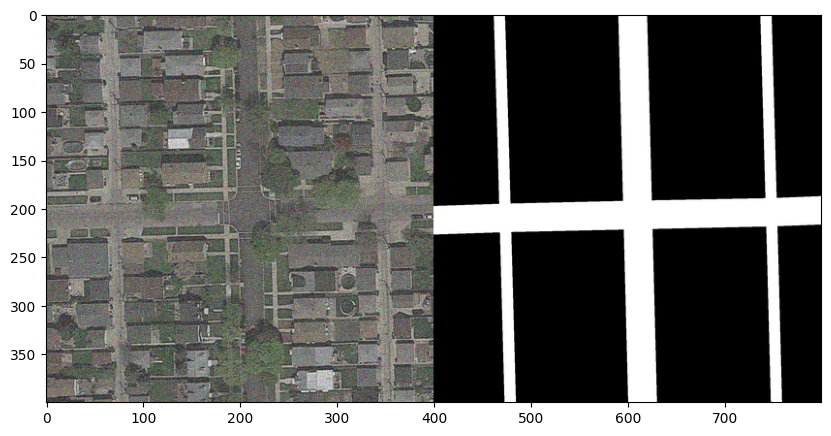

In [21]:
visualize(Augmented_Images, gt_imgs,index=0)